In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import lpips


def SNE(X1: np.ndarray, X2: np.ndarray) -> float:
    return np.sum((X1 - X2) ** 2)


def MSE(X1: np.ndarray, X2: np.ndarray) -> float:
    return np.mean((X1 - X2) ** 2)


def PSNR(X1: np.ndarray, X2: np.ndarray, max: int = 255) -> float:
    return 10 * np.log10(max**2 / MSE(X1, X2))


def SSIM(X1: np.ndarray, X2: np.ndarray, C1=0.01**2, C2=0.03**2) -> float:
    mu1 = np.mean(X1)
    mu2 = np.mean(X2)

    sigma1_sq = np.var(X1)
    sigma2_sq = np.var(X2)

    sigma12 = np.mean((X1 - mu1) * (X2 - mu2))

    numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2)

    return numerator / denominator


def LPIPS(X1: np.ndarray, X2: np.ndarray, net="alex") -> float:
    loss_fn = lpips.LPIPS(net=net, verbose=False)
    return loss_fn(X1, X2).item()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import torchvision.transforms as transforms
import os
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.restoration import richardson_lucy


def apply_gaussian_blur(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), kernel_size/3)


class DeblurringDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(256, 256)):
        self.image_paths = glob(os.path.join(root_folder, "*.png"))
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.target_size)
        blurred = apply_gaussian_blur(img)

        if self.transform:
            img = self.transform(img)
            blurred = self.transform(blurred)

        return blurred, img


class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for blurred, sharp in train_bar:
            blurred, sharp = blurred.to(device), sharp.to(device)
            optimizer.zero_grad()
            output = model(blurred)

            loss = criterion(output, sharp)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(train_loss=running_loss / len(train_bar))

        val_loss = 0.0
        model.eval()
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        with torch.no_grad():
            for blurred, sharp in val_bar:
                blurred, sharp = blurred.to(device), sharp.to(device)
                output = model(blurred)

                loss = criterion(output, sharp)
                val_loss += loss.item()
                val_bar.set_postfix(val_loss=val_loss / len(val_bar))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(os.getcwd(), "best_model.pth"))
            print(f"Model saved at epoch {epoch+1} with val_loss: {best_val_loss:.6f}")


def gaussian_psf(size, sigma):
    psf = np.zeros((size, size))
    psf[size // 2, size // 2] = 1
    psf = gaussian(psf, sigma=sigma)
    return psf / psf.sum()


def richardson_lucy_deblur(image, num_iter=30, psf_size=5):
    image = np.clip(image, 0, 1).astype(np.float32, copy=False)
    psf = gaussian_psf(psf_size, sigma=psf_size/3)

    if image.ndim == 2:
        return np.clip(richardson_lucy(image, psf, num_iter=num_iter), 0, 1)
    else:
        deblurred = np.zeros_like(image)
        for c in range(image.shape[-1]):
            deblurred[..., c] = richardson_lucy(image[..., c], psf, num_iter=num_iter)

    return np.clip(deblurred, 0, 1)


def visualize_results(model, dataloader, device='cuda'):
    model.to(device)
    model.eval()
    blurred, sharp = next(iter(dataloader))
    blurred = blurred.to(device)
    with torch.no_grad():
        output = model(blurred).cpu()

    num_images = len(blurred)
    fig, axes = plt.subplots(num_images, 4, figsize=(22, 6 * num_images))
    if num_images == 1:
        axes = axes.reshape(1, 4)
    for i in range(num_images):
        img_rl = blurred[i].permute(1, 2, 0).cpu().numpy()
        img_rl = richardson_lucy_deblur(img_rl)

        img_blurred = blurred[i].cpu().permute(1, 2, 0).numpy()
        img_output = output[i].cpu().permute(1, 2, 0).numpy()
        img_sharp = sharp[i].cpu().permute(1, 2, 0).numpy()

        axes[i, 0].imshow(img_blurred)
        axes[i, 0].set_title("Blurred Input", fontsize=16)
        axes[i, 0].axis("off")
        axes[i, 1].imshow(img_rl)
        axes[i, 1].set_title("Richardson-Lucy", fontsize=16)
        axes[i, 1].axis("off")
        axes[i, 2].imshow(img_output)
        axes[i, 2].set_title("Model Output", fontsize=16)
        axes[i, 2].axis("off")
        axes[i, 3].imshow(img_sharp)
        axes[i, 3].set_title("Ground Truth", fontsize=16)
        axes[i, 3].axis("off")

    plt.show()


def compute_metrics(model, dataloader, device="cuda"):
    model.to(device)
    model.eval()

    metrics_model_list = {"SNE": [], "MSE": [], "PSNR": [], "SSIM": [], "LPIPS": []}
    metrics_rl_list = {"SNE": [], "MSE": [], "PSNR": [], "SSIM": [], "LPIPS": []}

    with torch.no_grad():
        for blurred, sharp in tqdm(dataloader, desc="Processing Images", unit="batch"):
            blurred = blurred.to(device)
            sharp = sharp.to(device)
            output = model(blurred).cpu()

            num_images = len(blurred)

            for i in range(num_images):
                img_rl = blurred[i].permute(1, 2, 0).cpu().numpy()
                img_rl = richardson_lucy_deblur(img_rl)

                img_output = output[i].cpu().permute(1, 2, 0).numpy()
                img_sharp = sharp[i].cpu().permute(1, 2, 0).numpy()

                metrics_model_list["SNE"].append(SNE(img_output, img_sharp))
                metrics_model_list["MSE"].append(MSE(img_output, img_sharp))
                metrics_model_list["PSNR"].append(PSNR(img_output, img_sharp))
                metrics_model_list["SSIM"].append(SSIM(img_output, img_sharp))
                metrics_model_list["LPIPS"].append(LPIPS(torch.tensor(img_output).permute(2, 0, 1).unsqueeze(0),
                                                          torch.tensor(img_sharp).permute(2, 0, 1).unsqueeze(0)))

                metrics_rl_list["SNE"].append(SNE(img_rl, img_sharp))
                metrics_rl_list["MSE"].append(MSE(img_rl, img_sharp))
                metrics_rl_list["PSNR"].append(PSNR(img_rl, img_sharp))
                metrics_rl_list["SSIM"].append(SSIM(img_rl, img_sharp))
                metrics_rl_list["LPIPS"].append(LPIPS(torch.tensor(img_rl).permute(2, 0, 1).unsqueeze(0),
                                                       torch.tensor(img_sharp).permute(2, 0, 1).unsqueeze(0)))

    metrics_summary = {"Model": {}, "RL": {}}
    for metric in metrics_model_list.keys():
        metrics_summary["Model"][metric] = (np.mean(metrics_model_list[metric]), np.std(metrics_model_list[metric]))
        metrics_summary["RL"][metric] = (np.mean(metrics_rl_list[metric]), np.std(metrics_rl_list[metric]))

    print("\nMetrics Summary:")
    for method in metrics_summary:
        print(f"\n{method} Metrics:")
        for metric, (mean, std) in metrics_summary[method].items():
            print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

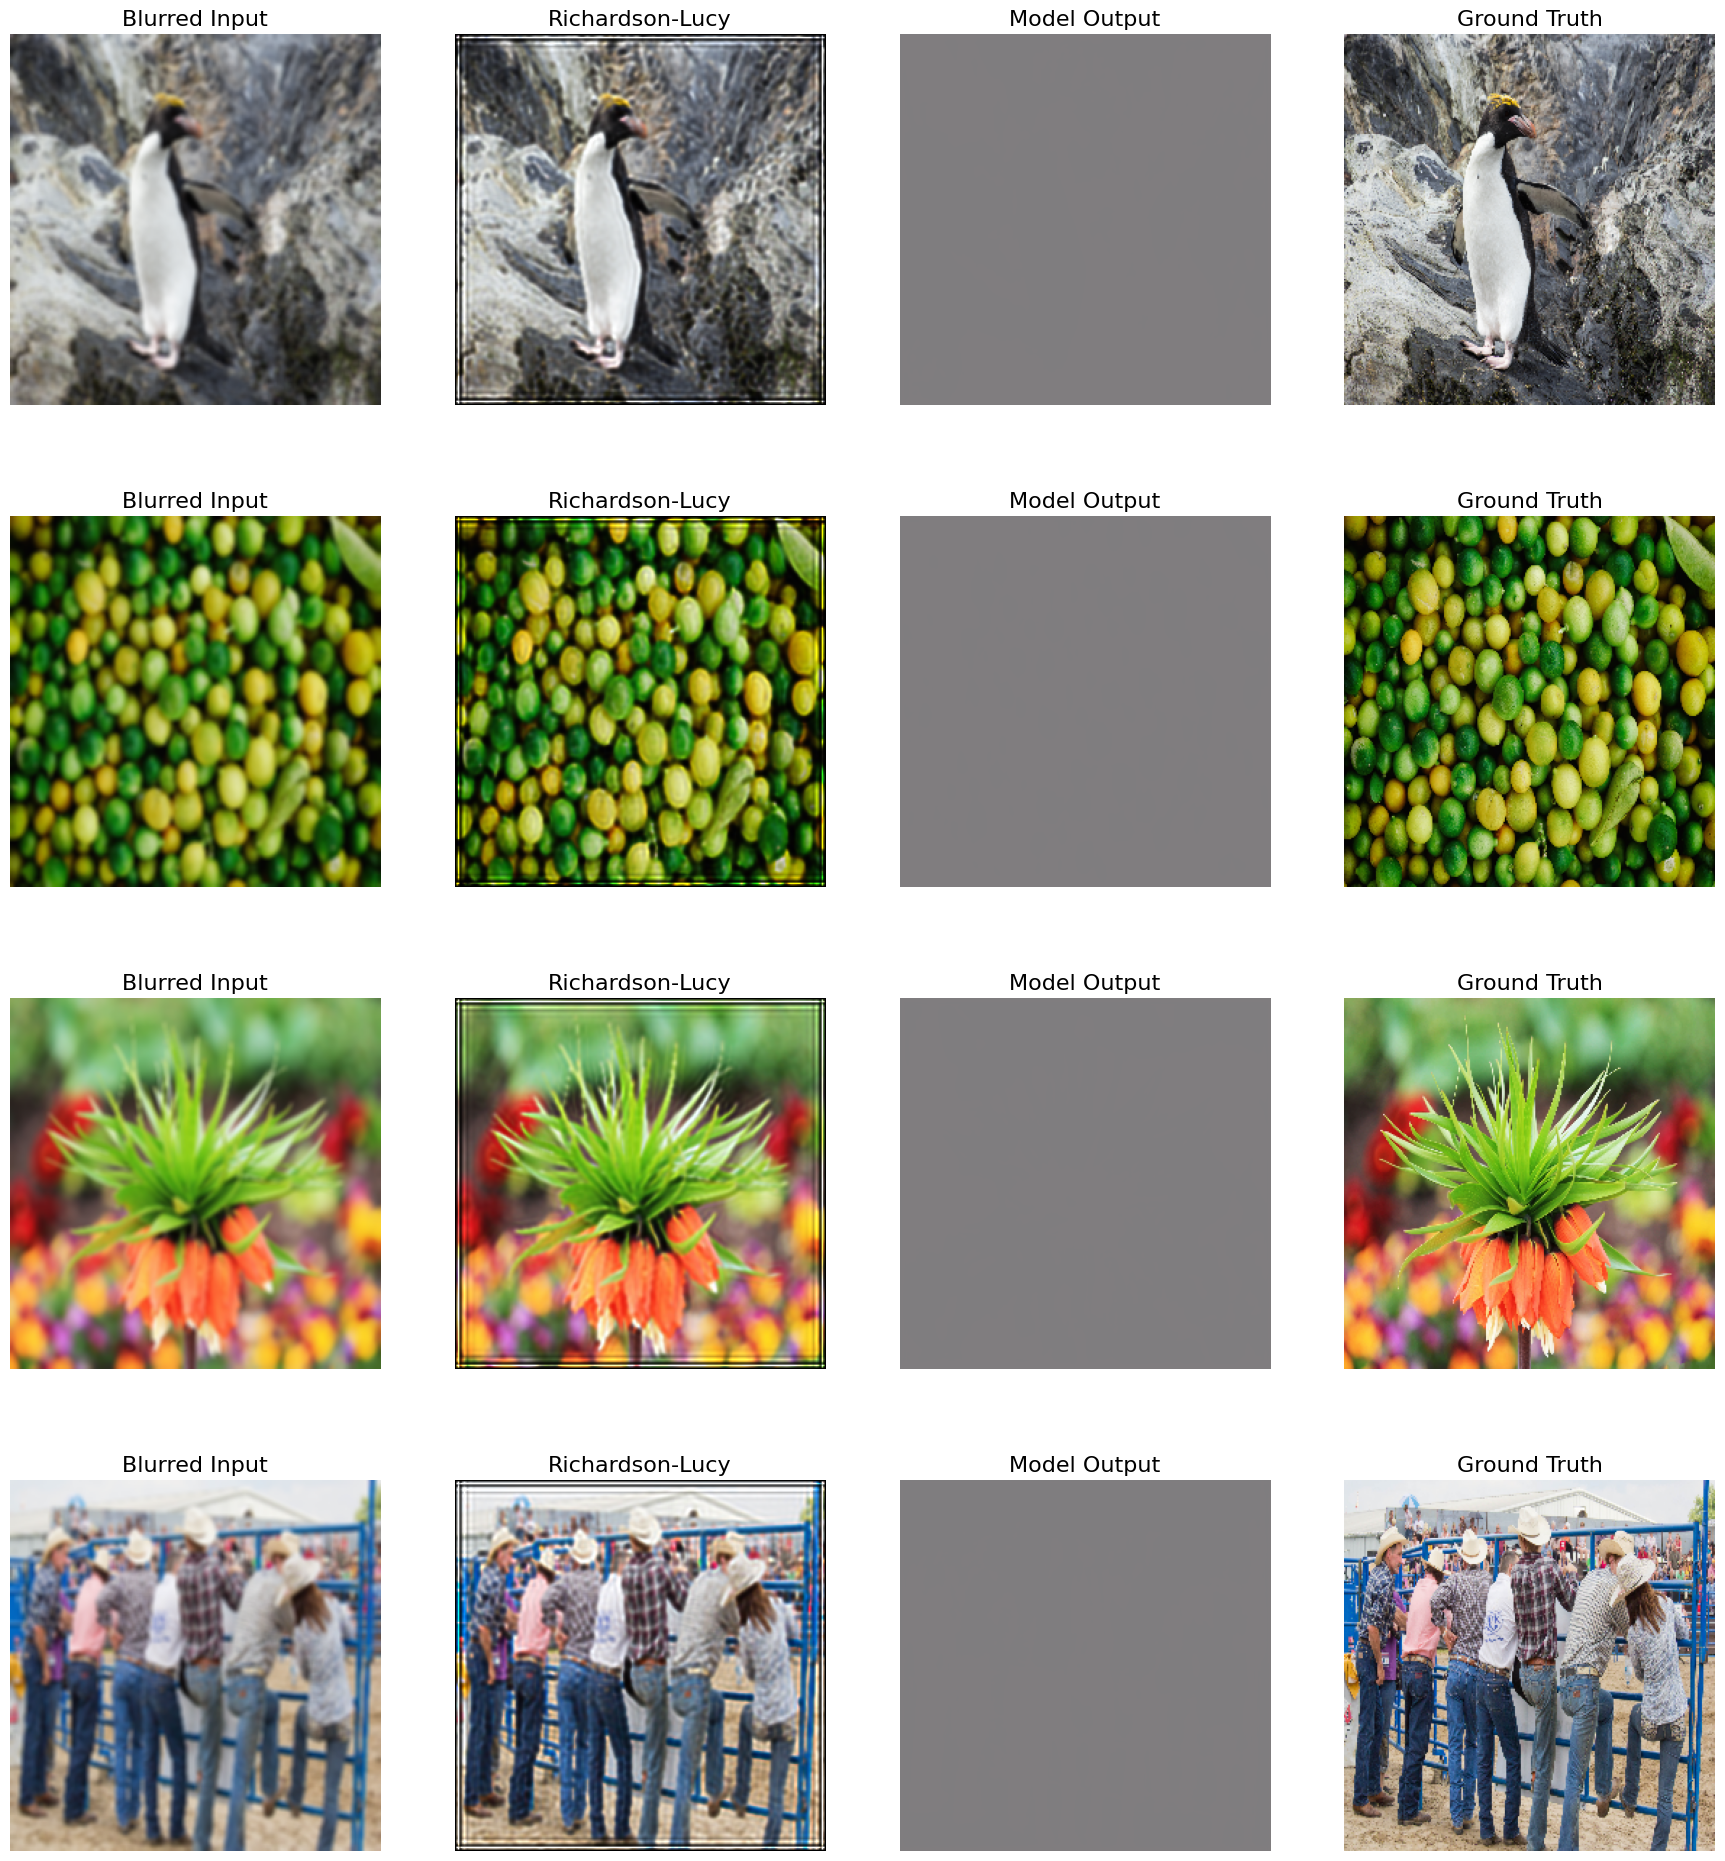

Epoch 1/5 [Training]:  50%|████▉     | 99/200 [00:47<00:48,  2.07it/s, train_loss=0.0138] 


KeyboardInterrupt: 

In [4]:
train_folder = os.getcwd() + "/DIV2K_train_HR"
val_folder = os.getcwd() + "/DIV2K_valid_HR"
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 4

train_dataset = DeblurringDataset(train_folder, transform)
val_dataset = DeblurringDataset(val_folder, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = DeblurCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

visualize_results(model, val_loader)

train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

C:\Users\idab\AppData\Local\Temp\ipykernel_13612\3335146140.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.getcwd() + "/model.pth"))

ValueError: volume and kernel should have the same dimensionality

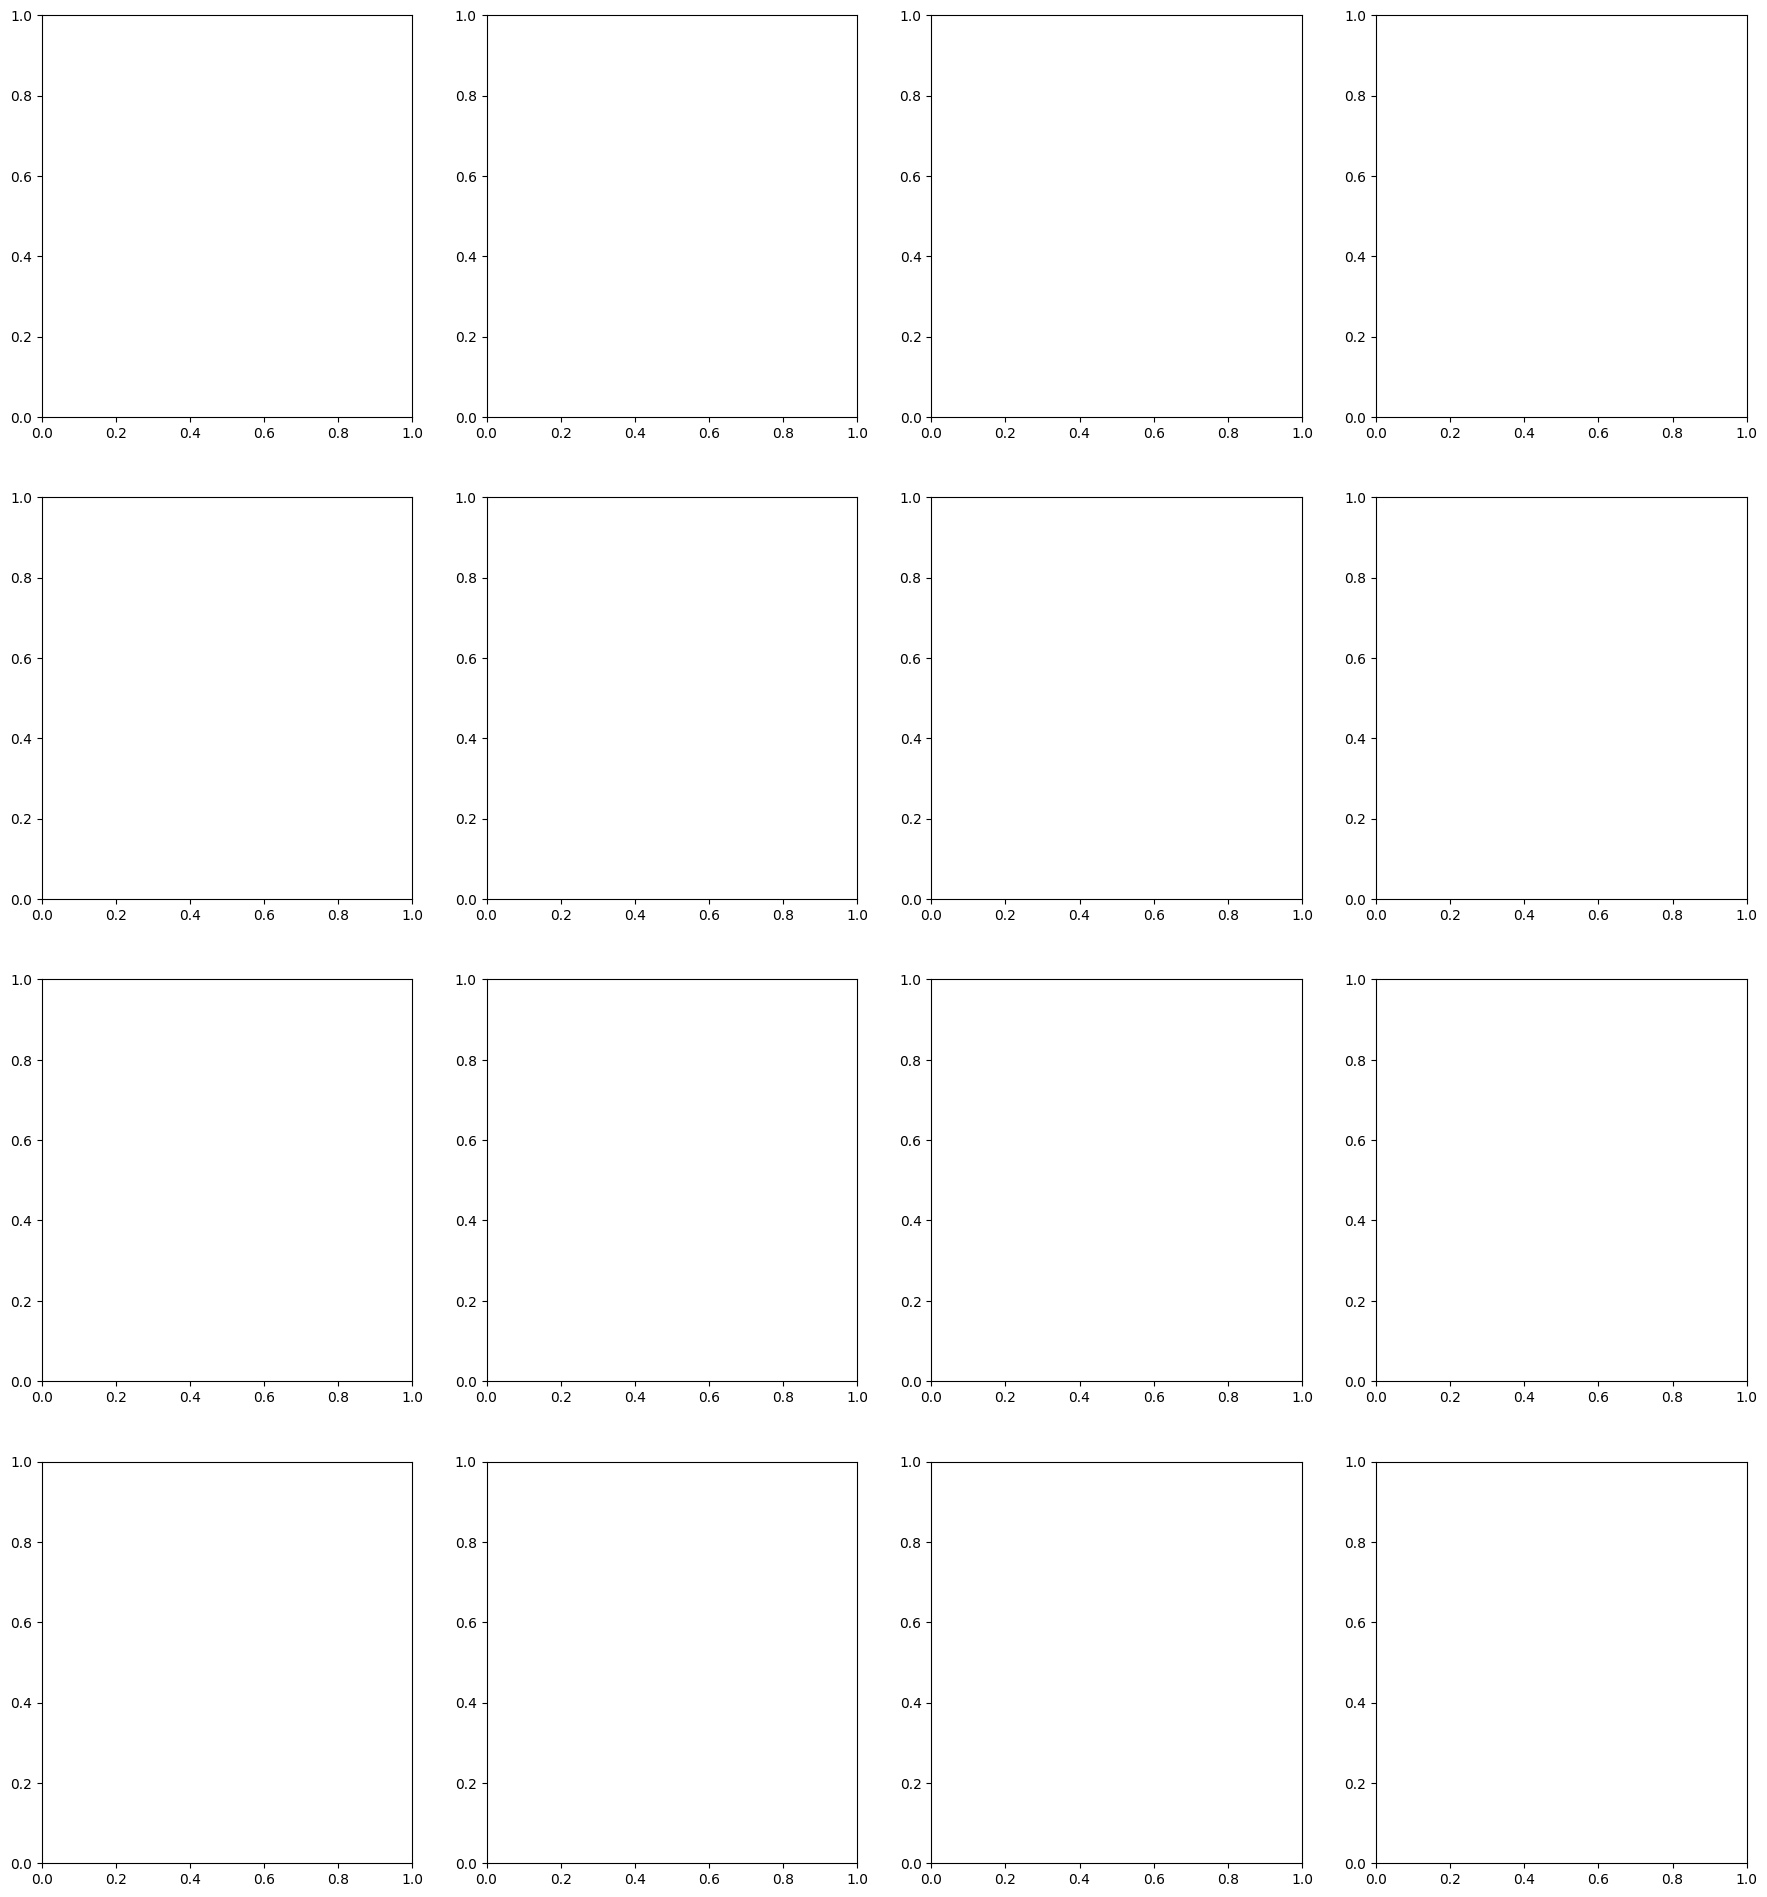

In [18]:
model.load_state_dict(torch.load(os.getcwd() + "/model.pth"))

visualize_results(model, val_loader)
compute_metrics(model, val_loader)